In [4]:
import pandas as pd
import numpy as np
import glob
import os
from scipy import stats
import tensorflow as tf
import math
import random
import matplotlib.pyplot as plt

fps = 120
moving_avg_len = 10
filter_value = 20
length = 150
threshold_pattern=0.4
#10.11. 목



def readFileData(file):
    column_names = ['wmx1', 'wmy1', 'wmz1']

    data = pd.read_csv(file, skiprows = 1 , names = column_names)
 
    wx = data["wmx1"]
    wy = data["wmy1"]
    wz = data["wmz1"]

    records=movingavg(wx,wy,wz)

    return np.dstack([wx,wy,wz])[0]

def readData(directory):
    records = []
    labels = np.empty(0)
    allFiles = glob.glob("*.csv")
    for i,file in enumerate(allFiles):
        fileName = os.path.basename(file)
        print("file name is", fileName,"\nnum is",i)
        (name, ext) = os.path.splitext(fileName)
        print("name is ",name,"ext is",ext)
        parts = name.split("_")
        if (True):
            label=parts[1]
            fileData = readFileData(file)
            records.append(fileData)
            #print("file data is ",fileData)
            labels=np.append(labels,label)

    print("* labels : ", labels)
    return (records, labels)

def movingavg(x,y,z):
    x_avg = np.zeros(moving_avg_len)/moving_avg_len
    y_avg = np.zeros(moving_avg_len)/moving_avg_len
    z_avg = np.zeros(moving_avg_len)/moving_avg_len
    x_avg = np.convolve(x,x_avg,'same')
    y_avg = np.convolve(y,y_avg,'same')
    z_avg = np.convolve(z,z_avg,'same')
    
    return [x_avg,y_avg,z_avg]

def splitData(records):##sungshil
    
    print("records_len is ",len(records))
    term=fps // 24
    record_sum = []
    record = []
    record_all = []
    sum_now = 0
    sum_pre = 0
    ct = 0
    start = 0
    end = 0
    num_pattern=[]
    for t in range(len(records)):
        ct = 0
        record_one=[]
        for i in range((len(records[t])//(term))-100):
            sum = 0
            record_x = np.empty(shape=[1],dtype=float)
            record_y = np.empty(shape=[1],dtype=float)
            record_z = np.empty(shape=[1],dtype=float)
            for j in range(fps//2):
                record_x = np.append(record_x,records[t][term*i+j][0])
                record_y = np.append(record_y,records[t][term*i+j][1])
                record_z = np.append(record_z,records[t][term*i+j][2])
            for k in range(fps//2 - 2):
                sum = sum+(record_x[k]-record_x[k+1])**2+(record_y[k]-record_y[k+1])**2+(record_z[k]-record_z[k+1])**2

            sum_pre = sum_now
            sum_now = sum
            record_sum.append(sum)
            if (sum_pre < threshold_pattern and sum_now > threshold_pattern):
                start = term * i
            if (sum_pre > threshold_pattern and sum_now < threshold_pattern):
                end = term * i  
                s = []
                if (end-start)>120:
                    ct = ct + 1
                    #print(">> start : ",start)
                    #print(" >> end : ",end,", step : " ,ct, ", length of end-start : ",(end-start))
                    for k in range(end-start):
                        #t=(records[0][term*i+j+k])
                        #print("t is",t)
                        s.append(records[t][start+k])
                        #print("s is ",s)
                    record_one.append(s)
        record_all.append(record_one)
        print("number of patterm : ",ct)
        num_pattern.append(ct)
        #print("average is",np.average(record_sum))


        plt.plot(record_sum[1500:2000])



       
    return (record_all,num_pattern)

def getRecordsMaxLength(records):
    maxLen = 0
    for record in records:
        if (len(record) > maxLen):
            maxLen = len(record)
        
    return maxLen

def shortenRecordsLen(records, length):
    ret1 = []
    #print("records[]",len(records))
    print(length)
    for num in range(len(records)):
        ret2=[]
        for index in range(len(records[num])):
            s = []
            if (len(records[num][index])>length):
                
                record = records[num][index]
                if len(record)<1000:
                    for i in range(length):
                        ret3=[]                      
                        t=i*(len(record)/length)
                        if t%1 == 0:
                            s.append(record[int(t)])
                        else:
                            a = t//1
                            s1 = t-a
                            s2 = a+1-t
                            for j in range(3):
                                ret3.append( s1*record[int(a)][j] + s2*record[int(a)][j] )
                            s.append(ret3)
                            print("s_len is",len(s))
                ret2.append(s)
                print("ret2_len is",len(ret2))
        ret1.append(ret2)

    return ret1

def weight_variable(shape):#가중치 생성
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):#편향 생성
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')

def apply_depthwise_conv(x,kernel_size,num_channels,depth):#각 채널마다 활성곱 수행후 ReLu활성화 함수로 pass
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))
    
def apply_max_pool(x,kernel_size,stride_size):#생성된 convolution층에 pooling 적용
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')

file name is Converted_circle_Sua_1012.csv 
num is 0
name is  Converted_circle_Sua_1012 ext is .csv
file name is Converted_triangle_Sua_1012.csv 
num is 1
name is  Converted_triangle_Sua_1012 ext is .csv
file name is Converted_X_Sungshil_1012.csv 
num is 2
name is  Converted_X_Sungshil_1012 ext is .csv
* labels :  ['circle' 'triangle' 'X']
**len_record :  3
records_len is  3
number of patterm :  116
number of patterm :  79
number of patterm :  98
labels_converted : ['circle' 'triangle' 'X']
labels_converted : [[0 1 0]
 [0 0 1]
 [1 0 0]]
3


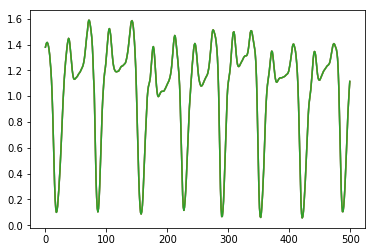

In [5]:
(records,labels) = readData("dr")
print("**len_record : ",len(records))
records,nums_pattern = splitData(records)
#records = shortenRecordsLen(records, length)
print("labels_converted :" ,labels)
labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)
print("labels_converted :" ,labels)
len_label=len(records)
print(len_label)



In [21]:
print(len(records[0][1]))

370


In [6]:
print(nums_pattern)
print(length)
records_1 = shortenRecordsLen(records, length)
print(len(records_1[0][0]))

[116, 79, 98]
150
150
s_len is 2
s_len is 3
s_len is 4
s_len is 5
s_len is 6
s_len is 7
s_len is 8
s_len is 9
s_len is 10
s_len is 11
s_len is 12
s_len is 13
s_len is 14
s_len is 15
s_len is 16
s_len is 17
s_len is 18
s_len is 19
s_len is 20
s_len is 21
s_len is 22
s_len is 23
s_len is 24
s_len is 25
s_len is 26
s_len is 27
s_len is 28
s_len is 29
s_len is 30
s_len is 32
s_len is 33
s_len is 34
s_len is 35
s_len is 36
s_len is 37
s_len is 38
s_len is 39
s_len is 40
s_len is 41
s_len is 42
s_len is 43
s_len is 44
s_len is 45
s_len is 46
s_len is 47
s_len is 48
s_len is 49
s_len is 50
s_len is 51
s_len is 52
s_len is 53
s_len is 54
s_len is 55
s_len is 56
s_len is 57
s_len is 58
s_len is 59
s_len is 60
s_len is 62
s_len is 63
s_len is 64
s_len is 65
s_len is 66
s_len is 67
s_len is 68
s_len is 69
s_len is 70
s_len is 71
s_len is 72
s_len is 73
s_len is 74
s_len is 75
s_len is 76
s_len is 77
s_len is 78
s_len is 79
s_len is 80
s_len is 81
s_len is 82
s_len is 83
s_len is 84
s_len is 85
s_

s_len is 46
s_len is 47
s_len is 48
s_len is 49
s_len is 50
s_len is 51
s_len is 52
s_len is 53
s_len is 54
s_len is 55
s_len is 56
s_len is 57
s_len is 58
s_len is 59
s_len is 60
s_len is 62
s_len is 63
s_len is 64
s_len is 65
s_len is 67
s_len is 68
s_len is 69
s_len is 70
s_len is 72
s_len is 73
s_len is 74
s_len is 75
s_len is 77
s_len is 78
s_len is 79
s_len is 80
s_len is 82
s_len is 83
s_len is 84
s_len is 85
s_len is 86
s_len is 87
s_len is 88
s_len is 89
s_len is 90
s_len is 91
s_len is 92
s_len is 93
s_len is 94
s_len is 95
s_len is 96
s_len is 97
s_len is 98
s_len is 99
s_len is 100
s_len is 101
s_len is 102
s_len is 103
s_len is 104
s_len is 105
s_len is 106
s_len is 107
s_len is 108
s_len is 109
s_len is 110
s_len is 111
s_len is 112
s_len is 113
s_len is 114
s_len is 115
s_len is 116
s_len is 117
s_len is 118
s_len is 119
s_len is 120
s_len is 122
s_len is 123
s_len is 124
s_len is 125
s_len is 127
s_len is 128
s_len is 129
s_len is 130
s_len is 132
s_len is 133
s_len is 

s_len is 97
s_len is 98
s_len is 99
s_len is 100
s_len is 101
s_len is 102
s_len is 103
s_len is 104
s_len is 105
s_len is 106
s_len is 107
s_len is 108
s_len is 109
s_len is 110
s_len is 111
s_len is 112
s_len is 113
s_len is 114
s_len is 115
s_len is 116
s_len is 117
s_len is 118
s_len is 119
s_len is 120
s_len is 122
s_len is 123
s_len is 124
s_len is 125
s_len is 126
s_len is 127
s_len is 128
s_len is 129
s_len is 130
s_len is 131
s_len is 132
s_len is 133
s_len is 134
s_len is 135
s_len is 136
s_len is 137
s_len is 138
s_len is 139
s_len is 140
s_len is 141
s_len is 142
s_len is 143
s_len is 144
s_len is 145
s_len is 146
s_len is 147
s_len is 148
s_len is 149
s_len is 150
ret2_len is 15
s_len is 2
s_len is 3
s_len is 4
s_len is 5
s_len is 6
s_len is 7
s_len is 8
s_len is 9
s_len is 10
s_len is 12
s_len is 13
s_len is 14
s_len is 15
s_len is 16
s_len is 17
s_len is 18
s_len is 19
s_len is 20
s_len is 22
s_len is 23
s_len is 24
s_len is 25
s_len is 26
s_len is 27
s_len is 28
s_len i

s_len is 84
s_len is 85
s_len is 86
s_len is 87
s_len is 88
s_len is 89
s_len is 90
s_len is 92
s_len is 93
s_len is 94
s_len is 95
s_len is 96
s_len is 97
s_len is 98
s_len is 99
s_len is 100
s_len is 101
s_len is 102
s_len is 103
s_len is 104
s_len is 105
s_len is 106
s_len is 107
s_len is 108
s_len is 109
s_len is 110
s_len is 111
s_len is 112
s_len is 113
s_len is 114
s_len is 115
s_len is 116
s_len is 117
s_len is 118
s_len is 119
s_len is 120
s_len is 122
s_len is 123
s_len is 124
s_len is 125
s_len is 126
s_len is 127
s_len is 128
s_len is 129
s_len is 130
s_len is 131
s_len is 132
s_len is 133
s_len is 134
s_len is 135
s_len is 136
s_len is 137
s_len is 138
s_len is 139
s_len is 140
s_len is 141
s_len is 142
s_len is 143
s_len is 144
s_len is 145
s_len is 146
s_len is 147
s_len is 148
s_len is 149
s_len is 150
ret2_len is 22
s_len is 2
s_len is 3
s_len is 4
s_len is 5
s_len is 6
s_len is 7
s_len is 8
s_len is 9
s_len is 10
s_len is 12
s_len is 13
s_len is 14
s_len is 15
s_len i

s_len is 124
s_len is 125
s_len is 126
s_len is 127
s_len is 128
s_len is 129
s_len is 130
s_len is 131
s_len is 132
s_len is 133
s_len is 134
s_len is 135
s_len is 136
s_len is 137
s_len is 138
s_len is 139
s_len is 140
s_len is 141
s_len is 142
s_len is 143
s_len is 144
s_len is 145
s_len is 146
s_len is 147
s_len is 148
s_len is 149
s_len is 150
ret2_len is 30
s_len is 2
s_len is 3
s_len is 4
s_len is 5
s_len is 6
s_len is 7
s_len is 8
s_len is 9
s_len is 10
s_len is 12
s_len is 13
s_len is 14
s_len is 15
s_len is 16
s_len is 17
s_len is 18
s_len is 19
s_len is 20
s_len is 22
s_len is 23
s_len is 24
s_len is 25
s_len is 26
s_len is 27
s_len is 28
s_len is 29
s_len is 30
s_len is 32
s_len is 33
s_len is 34
s_len is 35
s_len is 36
s_len is 37
s_len is 38
s_len is 39
s_len is 40
s_len is 42
s_len is 43
s_len is 44
s_len is 45
s_len is 46
s_len is 47
s_len is 48
s_len is 49
s_len is 50
s_len is 52
s_len is 53
s_len is 54
s_len is 55
s_len is 56
s_len is 57
s_len is 58
s_len is 59
s_len 

s_len is 15
s_len is 16
s_len is 17
s_len is 18
s_len is 19
s_len is 20
s_len is 21
s_len is 22
s_len is 23
s_len is 24
s_len is 25
s_len is 26
s_len is 27
s_len is 28
s_len is 29
s_len is 30
s_len is 32
s_len is 33
s_len is 34
s_len is 35
s_len is 36
s_len is 37
s_len is 38
s_len is 39
s_len is 40
s_len is 41
s_len is 42
s_len is 43
s_len is 44
s_len is 45
s_len is 46
s_len is 47
s_len is 48
s_len is 49
s_len is 50
s_len is 51
s_len is 52
s_len is 53
s_len is 54
s_len is 55
s_len is 56
s_len is 57
s_len is 58
s_len is 59
s_len is 60
s_len is 62
s_len is 63
s_len is 64
s_len is 65
s_len is 66
s_len is 67
s_len is 68
s_len is 69
s_len is 70
s_len is 71
s_len is 72
s_len is 73
s_len is 74
s_len is 75
s_len is 76
s_len is 77
s_len is 78
s_len is 79
s_len is 80
s_len is 81
s_len is 82
s_len is 83
s_len is 84
s_len is 85
s_len is 86
s_len is 87
s_len is 88
s_len is 89
s_len is 90
s_len is 92
s_len is 93
s_len is 94
s_len is 95
s_len is 96
s_len is 97
s_len is 98
s_len is 99
s_len is 100
s_l

s_len is 44
s_len is 45
s_len is 46
s_len is 47
s_len is 48
s_len is 49
s_len is 50
s_len is 51
s_len is 52
s_len is 53
s_len is 54
s_len is 55
s_len is 56
s_len is 57
s_len is 58
s_len is 59
s_len is 60
s_len is 62
s_len is 63
s_len is 64
s_len is 65
s_len is 66
s_len is 67
s_len is 68
s_len is 69
s_len is 70
s_len is 71
s_len is 72
s_len is 73
s_len is 74
s_len is 75
s_len is 76
s_len is 77
s_len is 78
s_len is 79
s_len is 80
s_len is 81
s_len is 82
s_len is 83
s_len is 84
s_len is 85
s_len is 86
s_len is 87
s_len is 88
s_len is 89
s_len is 90
s_len is 91
s_len is 92
s_len is 93
s_len is 94
s_len is 95
s_len is 96
s_len is 97
s_len is 98
s_len is 99
s_len is 100
s_len is 101
s_len is 102
s_len is 103
s_len is 104
s_len is 105
s_len is 106
s_len is 107
s_len is 108
s_len is 109
s_len is 110
s_len is 111
s_len is 112
s_len is 113
s_len is 114
s_len is 115
s_len is 116
s_len is 117
s_len is 118
s_len is 119
s_len is 120
s_len is 122
s_len is 123
s_len is 124
s_len is 125
s_len is 126
s_

s_len is 102
s_len is 103
s_len is 104
s_len is 105
s_len is 107
s_len is 108
s_len is 109
s_len is 110
s_len is 112
s_len is 113
s_len is 114
s_len is 115
s_len is 117
s_len is 118
s_len is 119
s_len is 120
s_len is 122
s_len is 123
s_len is 124
s_len is 125
s_len is 127
s_len is 128
s_len is 129
s_len is 130
s_len is 132
s_len is 133
s_len is 134
s_len is 135
s_len is 137
s_len is 138
s_len is 139
s_len is 140
s_len is 142
s_len is 143
s_len is 144
s_len is 145
s_len is 147
s_len is 148
s_len is 149
s_len is 150
ret2_len is 53
s_len is 2
s_len is 3
s_len is 5
s_len is 6
s_len is 8
s_len is 9
s_len is 11
s_len is 12
s_len is 14
s_len is 15
s_len is 17
s_len is 18
s_len is 20
s_len is 21
s_len is 23
s_len is 24
s_len is 26
s_len is 27
s_len is 29
s_len is 30
s_len is 32
s_len is 33
s_len is 35
s_len is 36
s_len is 38
s_len is 39
s_len is 41
s_len is 42
s_len is 44
s_len is 45
s_len is 47
s_len is 48
s_len is 50
s_len is 51
s_len is 53
s_len is 54
s_len is 56
s_len is 57
s_len is 59
s_l

s_len is 105
s_len is 106
s_len is 107
s_len is 108
s_len is 109
s_len is 110
s_len is 111
s_len is 112
s_len is 113
s_len is 114
s_len is 115
s_len is 116
s_len is 117
s_len is 118
s_len is 119
s_len is 120
s_len is 122
s_len is 123
s_len is 124
s_len is 125
s_len is 126
s_len is 127
s_len is 128
s_len is 129
s_len is 130
s_len is 131
s_len is 132
s_len is 133
s_len is 134
s_len is 135
s_len is 136
s_len is 137
s_len is 138
s_len is 139
s_len is 140
s_len is 141
s_len is 142
s_len is 143
s_len is 144
s_len is 145
s_len is 146
s_len is 147
s_len is 148
s_len is 149
s_len is 150
ret2_len is 61
s_len is 2
s_len is 3
s_len is 4
s_len is 5
s_len is 6
s_len is 7
s_len is 8
s_len is 9
s_len is 10
s_len is 11
s_len is 12
s_len is 13
s_len is 14
s_len is 15
s_len is 17
s_len is 18
s_len is 19
s_len is 20
s_len is 21
s_len is 22
s_len is 23
s_len is 24
s_len is 25
s_len is 26
s_len is 27
s_len is 28
s_len is 29
s_len is 30
s_len is 32
s_len is 33
s_len is 34
s_len is 35
s_len is 36
s_len is 37


s_len is 120
s_len is 122
s_len is 123
s_len is 124
s_len is 125
s_len is 126
s_len is 127
s_len is 128
s_len is 129
s_len is 130
s_len is 131
s_len is 132
s_len is 133
s_len is 134
s_len is 135
s_len is 136
s_len is 137
s_len is 138
s_len is 139
s_len is 140
s_len is 141
s_len is 142
s_len is 143
s_len is 144
s_len is 145
s_len is 146
s_len is 147
s_len is 148
s_len is 149
s_len is 150
ret2_len is 69
s_len is 2
s_len is 3
s_len is 4
s_len is 5
s_len is 7
s_len is 8
s_len is 9
s_len is 10
s_len is 12
s_len is 13
s_len is 14
s_len is 15
s_len is 17
s_len is 18
s_len is 19
s_len is 20
s_len is 22
s_len is 23
s_len is 24
s_len is 25
s_len is 27
s_len is 28
s_len is 29
s_len is 30
s_len is 32
s_len is 33
s_len is 34
s_len is 35
s_len is 37
s_len is 38
s_len is 39
s_len is 40
s_len is 42
s_len is 43
s_len is 44
s_len is 45
s_len is 47
s_len is 48
s_len is 49
s_len is 50
s_len is 52
s_len is 53
s_len is 54
s_len is 55
s_len is 57
s_len is 58
s_len is 59
s_len is 60
s_len is 62
s_len is 63
s_

s_len is 7
s_len is 8
s_len is 9
s_len is 10
s_len is 12
s_len is 13
s_len is 14
s_len is 15
s_len is 16
s_len is 17
s_len is 18
s_len is 19
s_len is 20
s_len is 22
s_len is 23
s_len is 24
s_len is 25
s_len is 26
s_len is 27
s_len is 28
s_len is 29
s_len is 30
s_len is 32
s_len is 33
s_len is 34
s_len is 35
s_len is 36
s_len is 37
s_len is 38
s_len is 39
s_len is 40
s_len is 42
s_len is 43
s_len is 44
s_len is 45
s_len is 46
s_len is 47
s_len is 48
s_len is 49
s_len is 50
s_len is 52
s_len is 53
s_len is 54
s_len is 55
s_len is 56
s_len is 57
s_len is 58
s_len is 59
s_len is 60
s_len is 62
s_len is 63
s_len is 64
s_len is 65
s_len is 66
s_len is 67
s_len is 68
s_len is 69
s_len is 70
s_len is 72
s_len is 73
s_len is 74
s_len is 75
s_len is 76
s_len is 77
s_len is 78
s_len is 79
s_len is 80
s_len is 82
s_len is 83
s_len is 84
s_len is 85
s_len is 86
s_len is 87
s_len is 88
s_len is 89
s_len is 90
s_len is 92
s_len is 93
s_len is 94
s_len is 95
s_len is 96
s_len is 97
s_len is 98
s_len i

s_len is 91
s_len is 92
s_len is 93
s_len is 94
s_len is 95
s_len is 96
s_len is 97
s_len is 98
s_len is 99
s_len is 100
s_len is 102
s_len is 103
s_len is 104
s_len is 105
s_len is 106
s_len is 107
s_len is 108
s_len is 109
s_len is 110
s_len is 112
s_len is 113
s_len is 114
s_len is 115
s_len is 116
s_len is 117
s_len is 118
s_len is 119
s_len is 120
s_len is 122
s_len is 123
s_len is 124
s_len is 125
s_len is 126
s_len is 127
s_len is 128
s_len is 129
s_len is 130
s_len is 132
s_len is 133
s_len is 134
s_len is 135
s_len is 136
s_len is 137
s_len is 138
s_len is 139
s_len is 140
s_len is 142
s_len is 143
s_len is 144
s_len is 145
s_len is 146
s_len is 147
s_len is 148
s_len is 149
s_len is 150
ret2_len is 84
s_len is 2
s_len is 4
s_len is 6
s_len is 8
s_len is 10
s_len is 12
s_len is 14
s_len is 16
s_len is 18
s_len is 20
s_len is 22
s_len is 24
s_len is 26
s_len is 28
s_len is 30
s_len is 32
s_len is 34
s_len is 36
s_len is 38
s_len is 40
s_len is 42
s_len is 44
s_len is 46
s_len i

s_len is 32
s_len is 33
s_len is 34
s_len is 35
s_len is 37
s_len is 38
s_len is 39
s_len is 40
s_len is 42
s_len is 43
s_len is 44
s_len is 45
s_len is 46
s_len is 47
s_len is 48
s_len is 49
s_len is 50
s_len is 51
s_len is 52
s_len is 53
s_len is 54
s_len is 55
s_len is 56
s_len is 57
s_len is 58
s_len is 59
s_len is 60
s_len is 62
s_len is 63
s_len is 64
s_len is 65
s_len is 67
s_len is 68
s_len is 69
s_len is 70
s_len is 72
s_len is 73
s_len is 74
s_len is 75
s_len is 77
s_len is 78
s_len is 79
s_len is 80
s_len is 82
s_len is 83
s_len is 84
s_len is 85
s_len is 86
s_len is 87
s_len is 88
s_len is 89
s_len is 90
s_len is 91
s_len is 92
s_len is 93
s_len is 94
s_len is 95
s_len is 96
s_len is 97
s_len is 98
s_len is 99
s_len is 100
s_len is 101
s_len is 102
s_len is 103
s_len is 104
s_len is 105
s_len is 106
s_len is 107
s_len is 108
s_len is 109
s_len is 110
s_len is 111
s_len is 112
s_len is 113
s_len is 114
s_len is 115
s_len is 116
s_len is 117
s_len is 118
s_len is 119
s_len is

s_len is 125
s_len is 126
s_len is 128
s_len is 129
s_len is 131
s_len is 132
s_len is 134
s_len is 135
s_len is 137
s_len is 138
s_len is 140
s_len is 141
s_len is 143
s_len is 144
s_len is 146
s_len is 147
s_len is 149
s_len is 150
ret2_len is 99
s_len is 2
s_len is 3
s_len is 4
s_len is 5
s_len is 6
s_len is 7
s_len is 8
s_len is 9
s_len is 10
s_len is 11
s_len is 12
s_len is 13
s_len is 14
s_len is 15
s_len is 17
s_len is 18
s_len is 19
s_len is 20
s_len is 21
s_len is 22
s_len is 23
s_len is 24
s_len is 25
s_len is 26
s_len is 27
s_len is 28
s_len is 29
s_len is 30
s_len is 32
s_len is 33
s_len is 34
s_len is 35
s_len is 36
s_len is 37
s_len is 38
s_len is 39
s_len is 40
s_len is 41
s_len is 42
s_len is 43
s_len is 44
s_len is 45
s_len is 47
s_len is 48
s_len is 49
s_len is 50
s_len is 51
s_len is 52
s_len is 53
s_len is 54
s_len is 55
s_len is 56
s_len is 57
s_len is 58
s_len is 59
s_len is 60
s_len is 62
s_len is 63
s_len is 64
s_len is 65
s_len is 66
s_len is 67
s_len is 68
s_l

s_len is 146
s_len is 147
s_len is 148
s_len is 149
s_len is 150
ret2_len is 106
s_len is 2
s_len is 3
s_len is 4
s_len is 5
s_len is 6
s_len is 7
s_len is 8
s_len is 9
s_len is 10
s_len is 11
s_len is 12
s_len is 13
s_len is 14
s_len is 15
s_len is 16
s_len is 17
s_len is 18
s_len is 19
s_len is 20
s_len is 21
s_len is 22
s_len is 23
s_len is 24
s_len is 25
s_len is 26
s_len is 27
s_len is 28
s_len is 29
s_len is 30
s_len is 32
s_len is 33
s_len is 34
s_len is 35
s_len is 36
s_len is 37
s_len is 38
s_len is 39
s_len is 40
s_len is 41
s_len is 42
s_len is 43
s_len is 44
s_len is 45
s_len is 46
s_len is 47
s_len is 48
s_len is 49
s_len is 50
s_len is 51
s_len is 52
s_len is 53
s_len is 54
s_len is 55
s_len is 56
s_len is 57
s_len is 58
s_len is 59
s_len is 60
s_len is 62
s_len is 63
s_len is 64
s_len is 65
s_len is 66
s_len is 67
s_len is 68
s_len is 69
s_len is 70
s_len is 71
s_len is 72
s_len is 73
s_len is 74
s_len is 75
s_len is 76
s_len is 77
s_len is 78
s_len is 79
s_len is 80
s_l

s_len is 4
s_len is 5
s_len is 6
s_len is 7
s_len is 8
s_len is 9
s_len is 10
s_len is 11
s_len is 12
s_len is 13
s_len is 14
s_len is 15
s_len is 16
s_len is 17
s_len is 18
s_len is 19
s_len is 20
s_len is 21
s_len is 22
s_len is 23
s_len is 24
s_len is 25
s_len is 26
s_len is 27
s_len is 28
s_len is 29
s_len is 30
s_len is 32
s_len is 33
s_len is 34
s_len is 35
s_len is 36
s_len is 37
s_len is 38
s_len is 39
s_len is 40
s_len is 41
s_len is 42
s_len is 43
s_len is 44
s_len is 45
s_len is 46
s_len is 47
s_len is 48
s_len is 49
s_len is 50
s_len is 51
s_len is 52
s_len is 53
s_len is 54
s_len is 55
s_len is 56
s_len is 57
s_len is 58
s_len is 59
s_len is 60
s_len is 62
s_len is 63
s_len is 64
s_len is 65
s_len is 66
s_len is 67
s_len is 68
s_len is 69
s_len is 70
s_len is 71
s_len is 72
s_len is 73
s_len is 74
s_len is 75
s_len is 76
s_len is 77
s_len is 78
s_len is 79
s_len is 80
s_len is 81
s_len is 82
s_len is 83
s_len is 84
s_len is 85
s_len is 86
s_len is 87
s_len is 88
s_len is 8

s_len is 146
s_len is 147
s_len is 148
s_len is 149
s_len is 150
ret2_len is 5
s_len is 2
s_len is 3
s_len is 4
s_len is 5
s_len is 6
s_len is 8
s_len is 9
s_len is 10
s_len is 11
s_len is 12
s_len is 14
s_len is 15
s_len is 16
s_len is 17
s_len is 18
s_len is 20
s_len is 21
s_len is 22
s_len is 23
s_len is 24
s_len is 26
s_len is 27
s_len is 28
s_len is 29
s_len is 30
s_len is 32
s_len is 33
s_len is 34
s_len is 35
s_len is 36
s_len is 38
s_len is 39
s_len is 40
s_len is 41
s_len is 42
s_len is 44
s_len is 45
s_len is 46
s_len is 47
s_len is 48
s_len is 50
s_len is 51
s_len is 52
s_len is 53
s_len is 54
s_len is 56
s_len is 57
s_len is 58
s_len is 59
s_len is 60
s_len is 62
s_len is 63
s_len is 64
s_len is 65
s_len is 66
s_len is 68
s_len is 69
s_len is 70
s_len is 71
s_len is 72
s_len is 74
s_len is 75
s_len is 76
s_len is 77
s_len is 78
s_len is 80
s_len is 81
s_len is 82
s_len is 83
s_len is 84
s_len is 86
s_len is 87
s_len is 88
s_len is 89
s_len is 90
s_len is 92
s_len is 93
s_le

s_len is 20
s_len is 21
s_len is 23
s_len is 24
s_len is 26
s_len is 27
s_len is 29
s_len is 30
s_len is 32
s_len is 33
s_len is 35
s_len is 36
s_len is 38
s_len is 39
s_len is 41
s_len is 42
s_len is 44
s_len is 45
s_len is 47
s_len is 48
s_len is 50
s_len is 51
s_len is 53
s_len is 54
s_len is 56
s_len is 57
s_len is 59
s_len is 60
s_len is 62
s_len is 63
s_len is 65
s_len is 66
s_len is 68
s_len is 69
s_len is 71
s_len is 72
s_len is 74
s_len is 75
s_len is 77
s_len is 78
s_len is 80
s_len is 81
s_len is 83
s_len is 84
s_len is 86
s_len is 87
s_len is 89
s_len is 90
s_len is 92
s_len is 93
s_len is 95
s_len is 96
s_len is 98
s_len is 99
s_len is 101
s_len is 102
s_len is 104
s_len is 105
s_len is 107
s_len is 108
s_len is 110
s_len is 111
s_len is 113
s_len is 114
s_len is 116
s_len is 117
s_len is 119
s_len is 120
s_len is 122
s_len is 123
s_len is 125
s_len is 126
s_len is 128
s_len is 129
s_len is 131
s_len is 132
s_len is 134
s_len is 135
s_len is 137
s_len is 138
s_len is 140
s

s_len is 9
s_len is 10
s_len is 11
s_len is 12
s_len is 14
s_len is 15
s_len is 16
s_len is 17
s_len is 18
s_len is 20
s_len is 21
s_len is 22
s_len is 23
s_len is 24
s_len is 26
s_len is 27
s_len is 28
s_len is 29
s_len is 30
s_len is 32
s_len is 33
s_len is 34
s_len is 35
s_len is 36
s_len is 38
s_len is 39
s_len is 40
s_len is 41
s_len is 42
s_len is 44
s_len is 45
s_len is 46
s_len is 47
s_len is 48
s_len is 50
s_len is 51
s_len is 52
s_len is 53
s_len is 54
s_len is 55
s_len is 56
s_len is 57
s_len is 58
s_len is 59
s_len is 60
s_len is 62
s_len is 63
s_len is 64
s_len is 65
s_len is 66
s_len is 68
s_len is 69
s_len is 70
s_len is 71
s_len is 72
s_len is 74
s_len is 75
s_len is 76
s_len is 77
s_len is 78
s_len is 80
s_len is 81
s_len is 82
s_len is 83
s_len is 84
s_len is 86
s_len is 87
s_len is 88
s_len is 89
s_len is 90
s_len is 92
s_len is 93
s_len is 94
s_len is 95
s_len is 96
s_len is 98
s_len is 99
s_len is 100
s_len is 101
s_len is 102
s_len is 103
s_len is 104
s_len is 105

s_len is 57
s_len is 59
s_len is 60
s_len is 62
s_len is 63
s_len is 65
s_len is 66
s_len is 68
s_len is 69
s_len is 71
s_len is 72
s_len is 74
s_len is 75
s_len is 77
s_len is 78
s_len is 80
s_len is 81
s_len is 83
s_len is 84
s_len is 86
s_len is 87
s_len is 89
s_len is 90
s_len is 92
s_len is 93
s_len is 95
s_len is 96
s_len is 98
s_len is 99
s_len is 101
s_len is 102
s_len is 104
s_len is 105
s_len is 107
s_len is 108
s_len is 110
s_len is 111
s_len is 113
s_len is 114
s_len is 116
s_len is 117
s_len is 119
s_len is 120
s_len is 122
s_len is 123
s_len is 125
s_len is 126
s_len is 128
s_len is 129
s_len is 131
s_len is 132
s_len is 134
s_len is 135
s_len is 137
s_len is 138
s_len is 140
s_len is 141
s_len is 143
s_len is 144
s_len is 146
s_len is 147
s_len is 149
s_len is 150
ret2_len is 29
s_len is 2
s_len is 3
s_len is 4
s_len is 5
s_len is 6
s_len is 7
s_len is 8
s_len is 9
s_len is 10
s_len is 11
s_len is 12
s_len is 13
s_len is 14
s_len is 15
s_len is 17
s_len is 18
s_len is 19

s_len is 97
s_len is 98
s_len is 99
s_len is 100
s_len is 101
s_len is 102
s_len is 103
s_len is 104
s_len is 105
s_len is 106
s_len is 107
s_len is 108
s_len is 109
s_len is 110
s_len is 111
s_len is 112
s_len is 113
s_len is 114
s_len is 115
s_len is 116
s_len is 117
s_len is 118
s_len is 119
s_len is 120
s_len is 122
s_len is 123
s_len is 124
s_len is 125
s_len is 126
s_len is 127
s_len is 128
s_len is 129
s_len is 130
s_len is 131
s_len is 132
s_len is 133
s_len is 134
s_len is 135
s_len is 136
s_len is 137
s_len is 138
s_len is 139
s_len is 140
s_len is 141
s_len is 142
s_len is 143
s_len is 144
s_len is 145
s_len is 146
s_len is 147
s_len is 148
s_len is 149
s_len is 150
ret2_len is 36
s_len is 2
s_len is 3
s_len is 4
s_len is 5
s_len is 6
s_len is 7
s_len is 8
s_len is 9
s_len is 10
s_len is 11
s_len is 12
s_len is 13
s_len is 14
s_len is 15
s_len is 17
s_len is 18
s_len is 19
s_len is 20
s_len is 21
s_len is 22
s_len is 23
s_len is 24
s_len is 25
s_len is 26
s_len is 27
s_len i

s_len is 24
s_len is 25
s_len is 26
s_len is 27
s_len is 28
s_len is 29
s_len is 30
s_len is 32
s_len is 33
s_len is 34
s_len is 35
s_len is 36
s_len is 37
s_len is 38
s_len is 39
s_len is 40
s_len is 41
s_len is 42
s_len is 43
s_len is 44
s_len is 45
s_len is 46
s_len is 47
s_len is 48
s_len is 49
s_len is 50
s_len is 51
s_len is 52
s_len is 53
s_len is 54
s_len is 55
s_len is 56
s_len is 57
s_len is 58
s_len is 59
s_len is 60
s_len is 62
s_len is 63
s_len is 64
s_len is 65
s_len is 66
s_len is 67
s_len is 68
s_len is 69
s_len is 70
s_len is 71
s_len is 72
s_len is 73
s_len is 74
s_len is 75
s_len is 76
s_len is 77
s_len is 78
s_len is 79
s_len is 80
s_len is 81
s_len is 82
s_len is 83
s_len is 84
s_len is 85
s_len is 86
s_len is 87
s_len is 88
s_len is 89
s_len is 90
s_len is 92
s_len is 93
s_len is 94
s_len is 95
s_len is 96
s_len is 97
s_len is 98
s_len is 99
s_len is 100
s_len is 101
s_len is 102
s_len is 103
s_len is 104
s_len is 105
s_len is 106
s_len is 107
s_len is 108
s_len i

s_len is 98
s_len is 99
s_len is 100
s_len is 101
s_len is 102
s_len is 103
s_len is 104
s_len is 105
s_len is 107
s_len is 108
s_len is 109
s_len is 110
s_len is 111
s_len is 112
s_len is 113
s_len is 114
s_len is 115
s_len is 116
s_len is 117
s_len is 118
s_len is 119
s_len is 120
s_len is 122
s_len is 123
s_len is 124
s_len is 125
s_len is 126
s_len is 127
s_len is 128
s_len is 129
s_len is 130
s_len is 131
s_len is 132
s_len is 133
s_len is 134
s_len is 135
s_len is 137
s_len is 138
s_len is 139
s_len is 140
s_len is 141
s_len is 142
s_len is 143
s_len is 144
s_len is 145
s_len is 146
s_len is 147
s_len is 148
s_len is 149
s_len is 150
ret2_len is 51
s_len is 2
s_len is 3
s_len is 4
s_len is 5
s_len is 6
s_len is 7
s_len is 8
s_len is 9
s_len is 10
s_len is 11
s_len is 12
s_len is 13
s_len is 14
s_len is 15
s_len is 17
s_len is 18
s_len is 19
s_len is 20
s_len is 21
s_len is 22
s_len is 23
s_len is 24
s_len is 25
s_len is 26
s_len is 27
s_len is 28
s_len is 29
s_len is 30
s_len is 

s_len is 115
s_len is 116
s_len is 117
s_len is 118
s_len is 119
s_len is 120
s_len is 122
s_len is 123
s_len is 124
s_len is 125
s_len is 126
s_len is 127
s_len is 128
s_len is 129
s_len is 130
s_len is 132
s_len is 133
s_len is 134
s_len is 135
s_len is 136
s_len is 137
s_len is 138
s_len is 139
s_len is 140
s_len is 142
s_len is 143
s_len is 144
s_len is 145
s_len is 146
s_len is 147
s_len is 148
s_len is 149
s_len is 150
ret2_len is 59
s_len is 2
s_len is 3
s_len is 4
s_len is 5
s_len is 6
s_len is 7
s_len is 8
s_len is 9
s_len is 10
s_len is 11
s_len is 12
s_len is 13
s_len is 14
s_len is 15
s_len is 17
s_len is 18
s_len is 19
s_len is 20
s_len is 21
s_len is 22
s_len is 23
s_len is 24
s_len is 25
s_len is 26
s_len is 27
s_len is 28
s_len is 29
s_len is 30
s_len is 32
s_len is 33
s_len is 34
s_len is 35
s_len is 36
s_len is 37
s_len is 38
s_len is 39
s_len is 40
s_len is 41
s_len is 42
s_len is 43
s_len is 44
s_len is 45
s_len is 47
s_len is 48
s_len is 49
s_len is 50
s_len is 51


s_len is 15
s_len is 17
s_len is 18
s_len is 19
s_len is 20
s_len is 21
s_len is 22
s_len is 23
s_len is 24
s_len is 25
s_len is 26
s_len is 27
s_len is 28
s_len is 29
s_len is 30
s_len is 32
s_len is 33
s_len is 34
s_len is 35
s_len is 36
s_len is 37
s_len is 38
s_len is 39
s_len is 40
s_len is 41
s_len is 42
s_len is 43
s_len is 44
s_len is 45
s_len is 46
s_len is 47
s_len is 48
s_len is 49
s_len is 50
s_len is 51
s_len is 52
s_len is 53
s_len is 54
s_len is 55
s_len is 56
s_len is 57
s_len is 58
s_len is 59
s_len is 60
s_len is 62
s_len is 63
s_len is 64
s_len is 65
s_len is 66
s_len is 67
s_len is 68
s_len is 69
s_len is 70
s_len is 71
s_len is 72
s_len is 73
s_len is 74
s_len is 75
s_len is 76
s_len is 77
s_len is 78
s_len is 79
s_len is 80
s_len is 81
s_len is 82
s_len is 83
s_len is 84
s_len is 85
s_len is 86
s_len is 87
s_len is 88
s_len is 89
s_len is 90
s_len is 91
s_len is 92
s_len is 93
s_len is 94
s_len is 95
s_len is 96
s_len is 97
s_len is 98
s_len is 99
s_len is 100
s_l

s_len is 58
s_len is 59
s_len is 60
s_len is 62
s_len is 63
s_len is 64
s_len is 65
s_len is 66
s_len is 67
s_len is 68
s_len is 69
s_len is 70
s_len is 72
s_len is 73
s_len is 74
s_len is 75
s_len is 76
s_len is 77
s_len is 78
s_len is 79
s_len is 80
s_len is 82
s_len is 83
s_len is 84
s_len is 85
s_len is 86
s_len is 87
s_len is 88
s_len is 89
s_len is 90
s_len is 91
s_len is 92
s_len is 93
s_len is 94
s_len is 95
s_len is 96
s_len is 97
s_len is 98
s_len is 99
s_len is 100
s_len is 102
s_len is 103
s_len is 104
s_len is 105
s_len is 106
s_len is 107
s_len is 108
s_len is 109
s_len is 110
s_len is 112
s_len is 113
s_len is 114
s_len is 115
s_len is 116
s_len is 117
s_len is 118
s_len is 119
s_len is 120
s_len is 122
s_len is 123
s_len is 124
s_len is 125
s_len is 126
s_len is 127
s_len is 128
s_len is 129
s_len is 130
s_len is 132
s_len is 133
s_len is 134
s_len is 135
s_len is 136
s_len is 137
s_len is 138
s_len is 139
s_len is 140
s_len is 142
s_len is 143
s_len is 144
s_len is 145

s_len is 71
s_len is 72
s_len is 73
s_len is 74
s_len is 75
s_len is 77
s_len is 78
s_len is 79
s_len is 80
s_len is 81
s_len is 82
s_len is 83
s_len is 84
s_len is 85
s_len is 86
s_len is 87
s_len is 88
s_len is 89
s_len is 90
s_len is 92
s_len is 93
s_len is 94
s_len is 95
s_len is 96
s_len is 97
s_len is 98
s_len is 99
s_len is 100
s_len is 101
s_len is 102
s_len is 103
s_len is 104
s_len is 105
s_len is 107
s_len is 108
s_len is 109
s_len is 110
s_len is 111
s_len is 112
s_len is 113
s_len is 114
s_len is 115
s_len is 116
s_len is 117
s_len is 118
s_len is 119
s_len is 120
s_len is 122
s_len is 123
s_len is 124
s_len is 125
s_len is 126
s_len is 127
s_len is 128
s_len is 129
s_len is 130
s_len is 131
s_len is 132
s_len is 133
s_len is 134
s_len is 135
s_len is 137
s_len is 138
s_len is 139
s_len is 140
s_len is 141
s_len is 142
s_len is 143
s_len is 144
s_len is 145
s_len is 146
s_len is 147
s_len is 148
s_len is 149
s_len is 150
ret2_len is 15
s_len is 2
s_len is 3
s_len is 4
s_le

s_len is 120
s_len is 122
s_len is 123
s_len is 124
s_len is 125
s_len is 126
s_len is 128
s_len is 129
s_len is 130
s_len is 131
s_len is 132
s_len is 134
s_len is 135
s_len is 136
s_len is 137
s_len is 138
s_len is 140
s_len is 141
s_len is 142
s_len is 143
s_len is 144
s_len is 146
s_len is 147
s_len is 148
s_len is 149
s_len is 150
ret2_len is 22
s_len is 2
s_len is 3
s_len is 4
s_len is 5
s_len is 6
s_len is 7
s_len is 8
s_len is 9
s_len is 10
s_len is 12
s_len is 13
s_len is 14
s_len is 15
s_len is 16
s_len is 17
s_len is 18
s_len is 19
s_len is 20
s_len is 22
s_len is 23
s_len is 24
s_len is 25
s_len is 26
s_len is 27
s_len is 28
s_len is 29
s_len is 30
s_len is 32
s_len is 33
s_len is 34
s_len is 35
s_len is 36
s_len is 37
s_len is 38
s_len is 39
s_len is 40
s_len is 42
s_len is 43
s_len is 44
s_len is 45
s_len is 46
s_len is 47
s_len is 48
s_len is 49
s_len is 50
s_len is 52
s_len is 53
s_len is 54
s_len is 55
s_len is 56
s_len is 57
s_len is 58
s_len is 59
s_len is 60
s_len i

s_len is 37
s_len is 38
s_len is 39
s_len is 40
s_len is 42
s_len is 43
s_len is 44
s_len is 45
s_len is 46
s_len is 47
s_len is 48
s_len is 49
s_len is 50
s_len is 52
s_len is 53
s_len is 54
s_len is 55
s_len is 56
s_len is 57
s_len is 58
s_len is 59
s_len is 60
s_len is 62
s_len is 63
s_len is 64
s_len is 65
s_len is 66
s_len is 67
s_len is 68
s_len is 69
s_len is 70
s_len is 72
s_len is 73
s_len is 74
s_len is 75
s_len is 76
s_len is 77
s_len is 78
s_len is 79
s_len is 80
s_len is 82
s_len is 83
s_len is 84
s_len is 85
s_len is 86
s_len is 87
s_len is 88
s_len is 89
s_len is 90
s_len is 92
s_len is 93
s_len is 94
s_len is 95
s_len is 96
s_len is 97
s_len is 98
s_len is 99
s_len is 100
s_len is 102
s_len is 103
s_len is 104
s_len is 105
s_len is 106
s_len is 107
s_len is 108
s_len is 109
s_len is 110
s_len is 112
s_len is 113
s_len is 114
s_len is 115
s_len is 116
s_len is 117
s_len is 118
s_len is 119
s_len is 120
s_len is 122
s_len is 123
s_len is 124
s_len is 125
s_len is 126
s_le

s_len is 128
s_len is 129
s_len is 130
s_len is 131
s_len is 132
s_len is 133
s_len is 134
s_len is 135
s_len is 137
s_len is 138
s_len is 139
s_len is 140
s_len is 141
s_len is 142
s_len is 143
s_len is 144
s_len is 145
s_len is 146
s_len is 147
s_len is 148
s_len is 149
s_len is 150
ret2_len is 37
s_len is 2
s_len is 3
s_len is 4
s_len is 5
s_len is 6
s_len is 7
s_len is 8
s_len is 9
s_len is 10
s_len is 11
s_len is 12
s_len is 13
s_len is 14
s_len is 15
s_len is 16
s_len is 17
s_len is 18
s_len is 19
s_len is 20
s_len is 21
s_len is 22
s_len is 23
s_len is 24
s_len is 25
s_len is 26
s_len is 27
s_len is 28
s_len is 29
s_len is 30
s_len is 32
s_len is 33
s_len is 34
s_len is 35
s_len is 36
s_len is 37
s_len is 38
s_len is 39
s_len is 40
s_len is 41
s_len is 42
s_len is 43
s_len is 44
s_len is 45
s_len is 46
s_len is 47
s_len is 48
s_len is 49
s_len is 50
s_len is 51
s_len is 52
s_len is 53
s_len is 54
s_len is 55
s_len is 56
s_len is 57
s_len is 58
s_len is 59
s_len is 60
s_len is 62

s_len is 12
s_len is 14
s_len is 15
s_len is 17
s_len is 18
s_len is 20
s_len is 21
s_len is 23
s_len is 24
s_len is 26
s_len is 27
s_len is 29
s_len is 30
s_len is 32
s_len is 33
s_len is 35
s_len is 36
s_len is 38
s_len is 39
s_len is 41
s_len is 42
s_len is 44
s_len is 45
s_len is 47
s_len is 48
s_len is 50
s_len is 51
s_len is 53
s_len is 54
s_len is 56
s_len is 57
s_len is 59
s_len is 60
s_len is 62
s_len is 63
s_len is 65
s_len is 66
s_len is 68
s_len is 69
s_len is 71
s_len is 72
s_len is 74
s_len is 75
s_len is 77
s_len is 78
s_len is 80
s_len is 81
s_len is 83
s_len is 84
s_len is 86
s_len is 87
s_len is 89
s_len is 90
s_len is 92
s_len is 93
s_len is 95
s_len is 96
s_len is 98
s_len is 99
s_len is 101
s_len is 102
s_len is 104
s_len is 105
s_len is 107
s_len is 108
s_len is 110
s_len is 111
s_len is 113
s_len is 114
s_len is 116
s_len is 117
s_len is 119
s_len is 120
s_len is 122
s_len is 123
s_len is 125
s_len is 126
s_len is 128
s_len is 129
s_len is 131
s_len is 132
s_len 

s_len is 89
s_len is 90
s_len is 92
s_len is 93
s_len is 94
s_len is 95
s_len is 96
s_len is 97
s_len is 98
s_len is 99
s_len is 100
s_len is 101
s_len is 102
s_len is 103
s_len is 104
s_len is 105
s_len is 107
s_len is 108
s_len is 109
s_len is 110
s_len is 111
s_len is 112
s_len is 113
s_len is 114
s_len is 115
s_len is 116
s_len is 117
s_len is 118
s_len is 119
s_len is 120
s_len is 122
s_len is 123
s_len is 124
s_len is 125
s_len is 126
s_len is 127
s_len is 128
s_len is 129
s_len is 130
s_len is 131
s_len is 132
s_len is 133
s_len is 134
s_len is 135
s_len is 137
s_len is 138
s_len is 139
s_len is 140
s_len is 141
s_len is 142
s_len is 143
s_len is 144
s_len is 145
s_len is 146
s_len is 147
s_len is 148
s_len is 149
s_len is 150
ret2_len is 54
s_len is 2
s_len is 3
s_len is 4
s_len is 5
s_len is 6
s_len is 7
s_len is 8
s_len is 9
s_len is 10
s_len is 11
s_len is 12
s_len is 13
s_len is 14
s_len is 15
s_len is 16
s_len is 17
s_len is 18
s_len is 19
s_len is 20
s_len is 21
s_len is 

s_len is 143
s_len is 144
s_len is 145
s_len is 146
s_len is 147
s_len is 148
s_len is 149
s_len is 150
ret2_len is 61
s_len is 2
s_len is 3
s_len is 4
s_len is 5
s_len is 6
s_len is 7
s_len is 8
s_len is 9
s_len is 10
s_len is 11
s_len is 12
s_len is 13
s_len is 14
s_len is 15
s_len is 17
s_len is 18
s_len is 19
s_len is 20
s_len is 21
s_len is 22
s_len is 23
s_len is 24
s_len is 25
s_len is 26
s_len is 27
s_len is 28
s_len is 29
s_len is 30
s_len is 32
s_len is 33
s_len is 34
s_len is 35
s_len is 36
s_len is 37
s_len is 38
s_len is 39
s_len is 40
s_len is 41
s_len is 42
s_len is 43
s_len is 44
s_len is 45
s_len is 47
s_len is 48
s_len is 49
s_len is 50
s_len is 51
s_len is 52
s_len is 53
s_len is 54
s_len is 55
s_len is 56
s_len is 57
s_len is 58
s_len is 59
s_len is 60
s_len is 62
s_len is 63
s_len is 64
s_len is 65
s_len is 66
s_len is 67
s_len is 68
s_len is 69
s_len is 70
s_len is 71
s_len is 72
s_len is 73
s_len is 74
s_len is 75
s_len is 77
s_len is 78
s_len is 79
s_len is 80
s

s_len is 65
s_len is 66
s_len is 68
s_len is 69
s_len is 71
s_len is 72
s_len is 74
s_len is 75
s_len is 77
s_len is 78
s_len is 80
s_len is 81
s_len is 83
s_len is 84
s_len is 86
s_len is 87
s_len is 89
s_len is 90
s_len is 92
s_len is 93
s_len is 95
s_len is 96
s_len is 98
s_len is 99
s_len is 100
s_len is 101
s_len is 102
s_len is 103
s_len is 104
s_len is 105
s_len is 106
s_len is 107
s_len is 108
s_len is 109
s_len is 110
s_len is 111
s_len is 113
s_len is 114
s_len is 116
s_len is 117
s_len is 119
s_len is 120
s_len is 122
s_len is 123
s_len is 125
s_len is 126
s_len is 128
s_len is 129
s_len is 131
s_len is 132
s_len is 134
s_len is 135
s_len is 137
s_len is 138
s_len is 140
s_len is 141
s_len is 143
s_len is 144
s_len is 146
s_len is 147
s_len is 149
s_len is 150
ret2_len is 69
s_len is 2
s_len is 3
s_len is 4
s_len is 5
s_len is 6
s_len is 7
s_len is 8
s_len is 9
s_len is 10
s_len is 11
s_len is 12
s_len is 13
s_len is 14
s_len is 15
s_len is 17
s_len is 18
s_len is 19
s_len i

s_len is 9
s_len is 10
s_len is 11
s_len is 12
s_len is 13
s_len is 14
s_len is 15
s_len is 16
s_len is 17
s_len is 18
s_len is 19
s_len is 20
s_len is 21
s_len is 22
s_len is 23
s_len is 24
s_len is 25
s_len is 26
s_len is 27
s_len is 28
s_len is 29
s_len is 30
s_len is 32
s_len is 33
s_len is 34
s_len is 35
s_len is 36
s_len is 37
s_len is 38
s_len is 39
s_len is 40
s_len is 41
s_len is 42
s_len is 43
s_len is 44
s_len is 45
s_len is 46
s_len is 47
s_len is 48
s_len is 49
s_len is 50
s_len is 51
s_len is 52
s_len is 53
s_len is 54
s_len is 55
s_len is 56
s_len is 57
s_len is 58
s_len is 59
s_len is 60
s_len is 62
s_len is 63
s_len is 64
s_len is 65
s_len is 66
s_len is 67
s_len is 68
s_len is 69
s_len is 70
s_len is 71
s_len is 72
s_len is 73
s_len is 74
s_len is 75
s_len is 76
s_len is 77
s_len is 78
s_len is 79
s_len is 80
s_len is 81
s_len is 82
s_len is 83
s_len is 84
s_len is 85
s_len is 86
s_len is 87
s_len is 88
s_len is 89
s_len is 90
s_len is 91
s_len is 92
s_len is 93
s_len

s_len is 22
s_len is 23
s_len is 24
s_len is 25
s_len is 26
s_len is 27
s_len is 28
s_len is 29
s_len is 30
s_len is 32
s_len is 33
s_len is 34
s_len is 35
s_len is 36
s_len is 37
s_len is 38
s_len is 39
s_len is 40
s_len is 41
s_len is 42
s_len is 43
s_len is 44
s_len is 45
s_len is 47
s_len is 48
s_len is 49
s_len is 50
s_len is 51
s_len is 52
s_len is 53
s_len is 54
s_len is 55
s_len is 56
s_len is 57
s_len is 58
s_len is 59
s_len is 60
s_len is 62
s_len is 63
s_len is 64
s_len is 65
s_len is 66
s_len is 67
s_len is 68
s_len is 69
s_len is 70
s_len is 71
s_len is 72
s_len is 73
s_len is 74
s_len is 75
s_len is 77
s_len is 78
s_len is 79
s_len is 80
s_len is 81
s_len is 82
s_len is 83
s_len is 84
s_len is 85
s_len is 86
s_len is 87
s_len is 88
s_len is 89
s_len is 90
s_len is 92
s_len is 93
s_len is 94
s_len is 95
s_len is 96
s_len is 97
s_len is 98
s_len is 99
s_len is 100
s_len is 101
s_len is 102
s_len is 103
s_len is 104
s_len is 105
s_len is 107
s_len is 108
s_len is 109
s_len i

s_len is 105
s_len is 106
s_len is 107
s_len is 108
s_len is 109
s_len is 110
s_len is 111
s_len is 112
s_len is 113
s_len is 114
s_len is 115
s_len is 116
s_len is 117
s_len is 118
s_len is 119
s_len is 120
s_len is 122
s_len is 123
s_len is 124
s_len is 125
s_len is 126
s_len is 127
s_len is 128
s_len is 129
s_len is 130
s_len is 131
s_len is 132
s_len is 133
s_len is 134
s_len is 135
s_len is 136
s_len is 137
s_len is 138
s_len is 139
s_len is 140
s_len is 141
s_len is 142
s_len is 143
s_len is 144
s_len is 145
s_len is 146
s_len is 147
s_len is 148
s_len is 149
s_len is 150
ret2_len is 89
s_len is 2
s_len is 3
s_len is 4
s_len is 5
s_len is 7
s_len is 8
s_len is 9
s_len is 10
s_len is 12
s_len is 13
s_len is 14
s_len is 15
s_len is 17
s_len is 18
s_len is 19
s_len is 20
s_len is 22
s_len is 23
s_len is 24
s_len is 25
s_len is 27
s_len is 28
s_len is 29
s_len is 30
s_len is 32
s_len is 33
s_len is 34
s_len is 35
s_len is 37
s_len is 38
s_len is 39
s_len is 40
s_len is 42
s_len is 43

s_len is 47
s_len is 48
s_len is 49
s_len is 50
s_len is 51
s_len is 52
s_len is 53
s_len is 54
s_len is 55
s_len is 56
s_len is 57
s_len is 58
s_len is 59
s_len is 60
s_len is 62
s_len is 63
s_len is 64
s_len is 65
s_len is 66
s_len is 67
s_len is 68
s_len is 69
s_len is 70
s_len is 71
s_len is 72
s_len is 73
s_len is 74
s_len is 75
s_len is 77
s_len is 78
s_len is 79
s_len is 80
s_len is 81
s_len is 82
s_len is 83
s_len is 84
s_len is 85
s_len is 86
s_len is 87
s_len is 88
s_len is 89
s_len is 90
s_len is 92
s_len is 93
s_len is 94
s_len is 95
s_len is 96
s_len is 97
s_len is 98
s_len is 99
s_len is 100
s_len is 101
s_len is 102
s_len is 103
s_len is 104
s_len is 105
s_len is 107
s_len is 108
s_len is 109
s_len is 110
s_len is 111
s_len is 112
s_len is 113
s_len is 114
s_len is 115
s_len is 116
s_len is 117
s_len is 118
s_len is 119
s_len is 120
s_len is 122
s_len is 123
s_len is 124
s_len is 125
s_len is 126
s_len is 127
s_len is 128
s_len is 129
s_len is 130
s_len is 131
s_len is 1

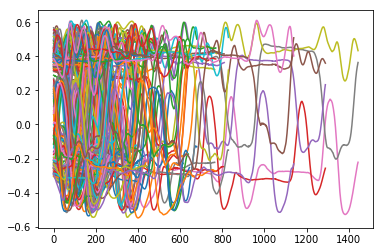

In [14]:
for i in range(len(records[1])):
    plt.plot(records[1][i])

In [128]:
records = np.asarray(records)
reshaped_records = records.reshape(len(records),1,200, 3) #recoed를 1차원으로 reshape
print(reshaped_records)

ValueError: cannot reshape array of size 9 into shape (9,1,200,3)

In [4]:
train_test_split = np.random.rand(len(reshaped_records)) < 0.70
print(train_test_split)
train_x = reshaped_records[train_test_split]
print("len(train_x) : ",len(train_x))
print(train_x)
train_y = labels[train_test_split]
test_x = reshaped_records[~train_test_split]
test_y = labels[~train_test_split]


[ True  True  True  True  True False  True  True False False False  True
 False  True False  True  True  True False  True  True  True  True  True
  True  True  True False  True  True  True  True  True False False  True
  True  True  True  True  True  True False False  True  True  True False
  True  True False  True  True  True False  True  True False  True  True
 False  True  True  True  True False  True  True False  True False  True
  True  True  True  True False  True False False  True False  True  True
  True False  True False  True  True  True  True False  True  True  True
  True False False False  True  True  True False False  True  True  True
  True  True  True  True  True  True False False  True  True  True  True
 False  True False]
len(train_x) :  87
[[[[-0.247097   -0.3659703   0.4844977 ]
   [-0.2472932  -0.3657586   0.4846356 ]
   [-0.2476161  -0.365464    0.48479   ]
   ...
   [ 0.02517822  0.1576575   0.4624478 ]
   [ 0.01866563  0.1680359   0.4599203 ]
   [ 0.01163944  0.

In [5]:
input_height = 1
input_width = 200
num_labels = 1
num_channels = 3 

batch_size = 10
kernel_size = 60 #??
depth = 60
num_hidden = 1000

learning_rate = 0.0001
training_epochs = 8

total_batches = train_x.shape[0] // batch_size

In [6]:
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
# input data
Y = tf.placeholder(tf.float32, shape=[None,num_labels])
# output data

c = apply_depthwise_conv(X,kernel_size,num_channels,depth) #1d convolution
p = apply_max_pool(c,20,2) #1d Max-Pooling
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10) #1d convolution

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)
# softmax

In [7]:
loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [9]:

with tf.Session() as session: 
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):    
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print ("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ", session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    print ("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))



Epoch:  0  Training Loss:  -0.0  Training Accuracy:  1.0
Epoch:  1  Training Loss:  -0.0  Training Accuracy:  1.0
Epoch:  2  Training Loss:  -0.0  Training Accuracy:  1.0
Epoch:  3  Training Loss:  -0.0  Training Accuracy:  1.0
Epoch:  4  Training Loss:  -0.0  Training Accuracy:  1.0
Epoch:  5  Training Loss:  -0.0  Training Accuracy:  1.0
Epoch:  6  Training Loss:  -0.0  Training Accuracy:  1.0


KeyboardInterrupt: 